# Estimation and testing of Fama French’s 5-factor model

In Asset Pricing, the excess return on a stock is broken down as follows:

$$
R_{it}-RF_{t} = \alpha_{i} +\sum_{j=1}^{k} \beta_{i}^{j} f_{jt} + e_{it}
$$
Where
- $R_{it}$ is the return of the stock *i* on date *t*,
- $RF_{t}$ is the risk-free rate on date *t*,
- the $f_{it}, i=1,..,k$ are *k* factors explaining common variations in returns and non-diversifiable risk
- the $\beta_{i}^{j},j=1...,k$ is the exposure of the asset *i* to the factor $f_{jt}$
- $e_{it}$ is the component specific to the asset *i* representing the diversifiable risk with $E(e_{it})=0$

If the factors are correctly chosen, that is to say they represent the variations in expected returns, we will have $\alpha_{i}=0$

**Fama and French (1993)** (Common risk factors in the returns on stocks and bonds, Journal of Financial Economics, 33 (1), pp. 3-56) propose a three-factor model to analyze returns stocks or stock portfolios.
In the 3-factor model, the average return of a stock is assumed to be correlated with:

1. The return on the market portfolio corrected for the risk-free rate: $Mkt-RF$
2. The *Size* of the company measured by its market capitalization (number of shares in circulation $\times$ price of a share).
     - This effect is measured by the factor $SMB_{t}$ equal to the difference in return of a portfolio of small companies minus that of a portfolio of large companies.
3. The book to market ratio *B/M* (ratio of book value and market value). A company with a high B/M ratio will be rather undervalued and is expected to have a high rate of return.
     - This effect is measured by the factor $HML_{t}$ calculated as the difference in returns between portfolios with high and low B/M ratios.

These three factors cannot fully explain the variations in expected returns. **Fama and French (2015)** ('A five-factor asset pricing model', Journal of Financial Economics, 116 1-22) add two additional factors taking into account:

4. The anticipated profitability of companies: higher anticipated earnings tend to increase the rate of return (all other things being equal). The $RMW_{t}$ factor is the difference in returns between a portfolio of companies with high (robust) and low (weak) profitability.
5. Anticipated corporate investments: higher investments tend to reduce the rate of return (less dividends therefore smaller market value). The $CMA_{t}$ factor is the difference between a portfolio of companies with a low level of investment (conservative) and companies with a high level of investment (aggressive)

The objective of this sheet will be to use these factors to estimate the decomposition of the returns of a set of stock portfolios from the NYSE, AMEX and Nasdaq.
We will check to what extent these factors correctly explain the anticipated returns.

    
The data can be found on the Kenneth French website
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
    
    
**In parts III and IV, estimates must be made over the period 1963-07-01 to 2023-07-01**


**You can add your answers (codes, display and comments of results) directly in the notebook. You save it with your name.**

## I. The 5 factors of Fama-French

#### 1. Data import

The Fama-French 5 factor data is stored in the file "F-F_Research_Data_5_Factors_2x3.csv".

Import monthly observations of these factors from "1963-07-01".

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
column_names = ['datetime', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

data = pd.read_csv('/Users/nathanliesse/Documents/bureau/FAC/M1/S1/info - python/Project_GroupRenzhiLIU/F-F_Research_Data_5_Factors_2x3.csv',
                header=None,
                names=column_names,
                skiprows=4,
                nrows = 723)

print(data)

     datetime  Mkt-RF   SMB   HML   RMW   CMA    RF
0      196307   -0.39 -0.41 -0.97  0.68 -1.18  0.27
1      196308    5.07 -0.80  1.80  0.36 -0.35  0.25
2      196309   -1.57 -0.52  0.13 -0.71  0.29  0.27
3      196310    2.53 -1.39 -0.10  2.80 -2.01  0.29
4      196311   -0.85 -0.88  1.75 -0.51  2.24  0.27
..        ...     ...   ...   ...   ...   ...   ...
718    202305    0.35 -0.38 -7.72 -1.81 -7.22  0.36
719    202306    6.46  1.34 -0.26  2.18 -1.62  0.40
720    202307    3.21  2.86  4.11 -0.57  0.57  0.45
721    202308   -2.39 -3.65 -1.06  3.43 -2.37  0.45
722    202309   -5.24 -1.79  1.52  1.87 -0.82  0.43

[723 rows x 7 columns]


#### 2. Checking for missing variables

In [3]:
# Checking for missing value. If the sum = 0 there is no missing values.
missing_values = data.isnull().sum()
print(missing_values)

print(data.info())

datetime    0
Mkt-RF      0
SMB         0
HML         0
RMW         0
CMA         0
RF          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  723 non-null    int64  
 1   Mkt-RF    723 non-null    float64
 2   SMB       723 non-null    float64
 3   HML       723 non-null    float64
 4   RMW       723 non-null    float64
 5   CMA       723 non-null    float64
 6   RF        723 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 39.7 KB
None


We use two ways to check for missing values: with a sum and with a python function. The sum, equal to 0 for each columns of data, shows us that there is no missing value. Data.info() confirms this conclusion. Indeed, there are 723 entries and 723 non-null values.

#### 3. Date formatting + Risk-free rate

1. Transform dates into dataframe index
2. Store the risk-free rate in a new DataFrame
3. Store the 5 factors presented above in a new DataFrame

In [4]:
# Transform dates into dataframe index
data["datetime"]=pd.to_datetime(data["datetime"],format="%Y%m")
data.set_index('datetime', inplace=True)
data.index.name = None
data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27


In [5]:
# Storage of the risk-free rate in a new DataFrame
df_risk_free = data[['RF']]
df_risk_free.head()

,RF
1963-07-01,0.27
1963-08-01,0.25
1963-09-01,0.27
1963-10-01,0.29
1963-11-01,0.27


In [6]:
# Storage of the 5 factors presented above in a new DataFrame (df_factors)
df_factors = data[["Mkt-RF",'SMB','HML','RMW','CMA']]
df_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18
1963-08-01,5.07,-0.80,1.80,0.36,-0.35
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24


#### 4. Graphical representation of factors

Plot the 5 factors

In [ ]:
df_factors.dtypes

In [7]:
#Conversion of all columns into flat format
df_factors = df_factors.apply(pd.to_numeric)

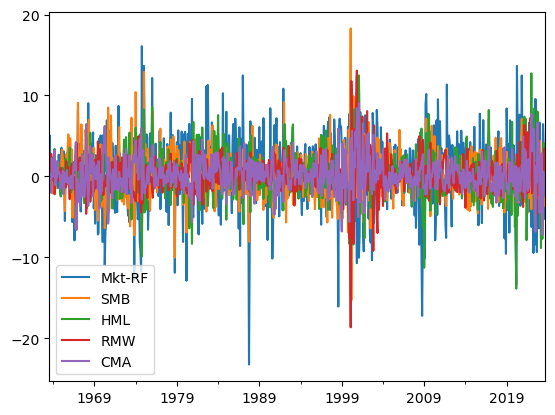

In [8]:
df_factors.plot()
plt.show()

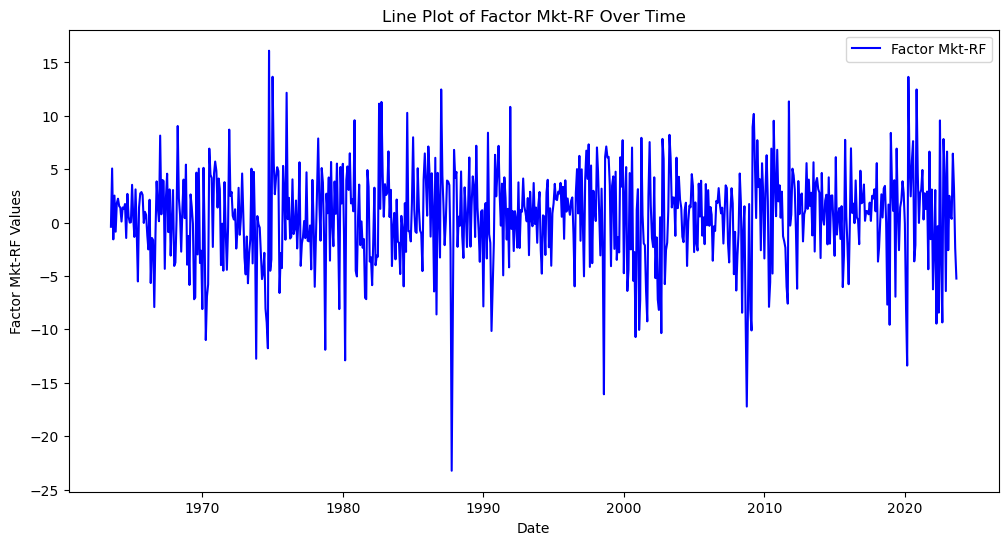

In [9]:
selected_factor = 'Mkt-RF'
plt.figure(figsize=(12, 6))
plt.plot(data.index, df_factors[selected_factor], linestyle='-', color='blue', label=f'Factor {selected_factor}')
plt.title(f'Line Plot of Factor {selected_factor} Over Time')
plt.xlabel('Date')
plt.ylabel(f'Factor {selected_factor} Values')
plt.legend()
plt.show()

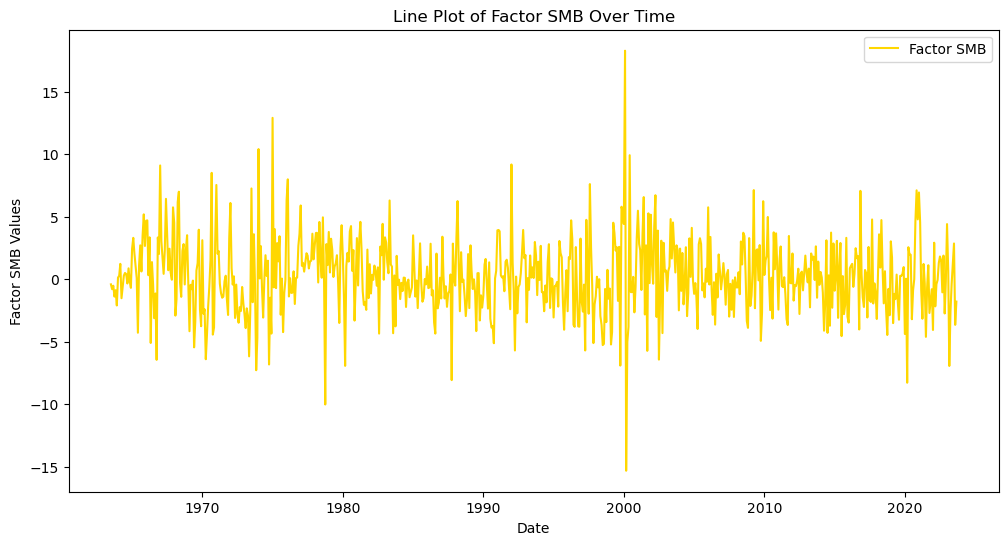

In [10]:
selected_factor = 'SMB'
plt.figure(figsize=(12, 6))
plt.plot(data.index, df_factors[selected_factor], linestyle='-', color='gold', label=f'Factor {selected_factor}')
plt.title(f'Line Plot of Factor {selected_factor} Over Time')
plt.xlabel('Date')
plt.ylabel(f'Factor {selected_factor} Values')
plt.legend()
plt.show()

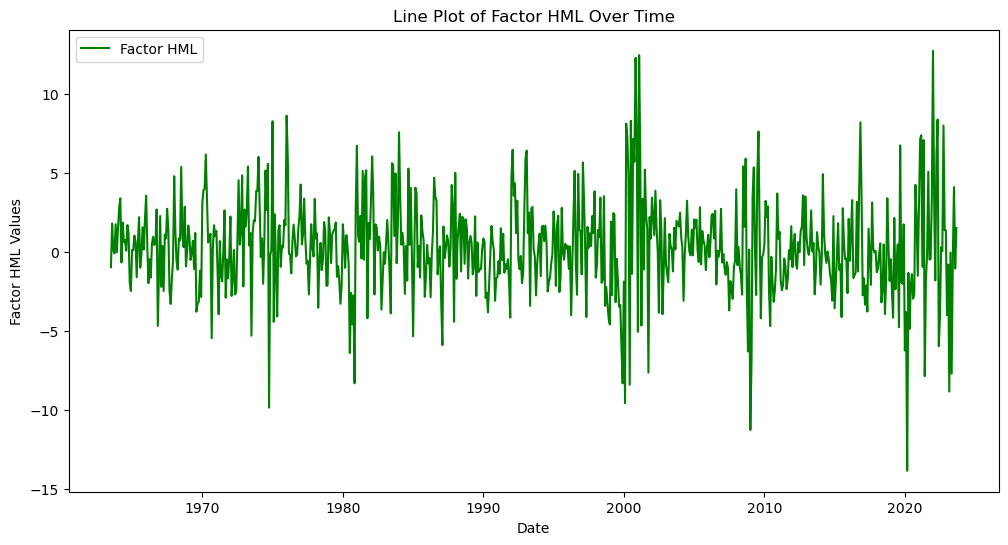

In [11]:
selected_factor = 'HML'
plt.figure(figsize=(12, 6))
plt.plot(data.index, df_factors[selected_factor], linestyle='-', color='green', label=f'Factor {selected_factor}')
plt.title(f'Line Plot of Factor {selected_factor} Over Time')
plt.xlabel('Date')
plt.ylabel(f'Factor {selected_factor} Values')
plt.legend()
plt.show()

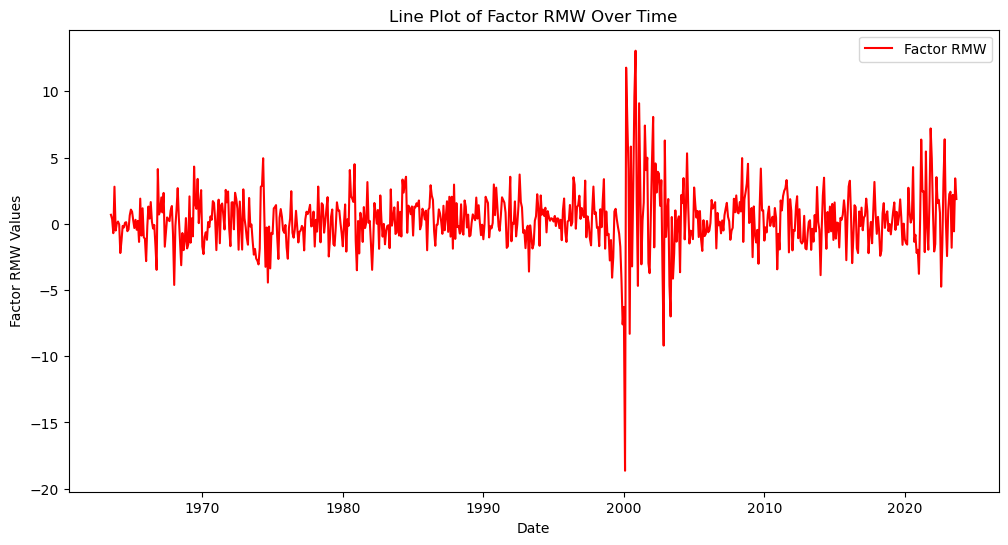

In [12]:
selected_factor = 'RMW'
plt.figure(figsize=(12, 6))
plt.plot(data.index, df_factors[selected_factor], linestyle='-', color='red', label=f'Factor {selected_factor}')
plt.title(f'Line Plot of Factor {selected_factor} Over Time')
plt.xlabel('Date')
plt.ylabel(f'Factor {selected_factor} Values')
plt.legend()
plt.show()

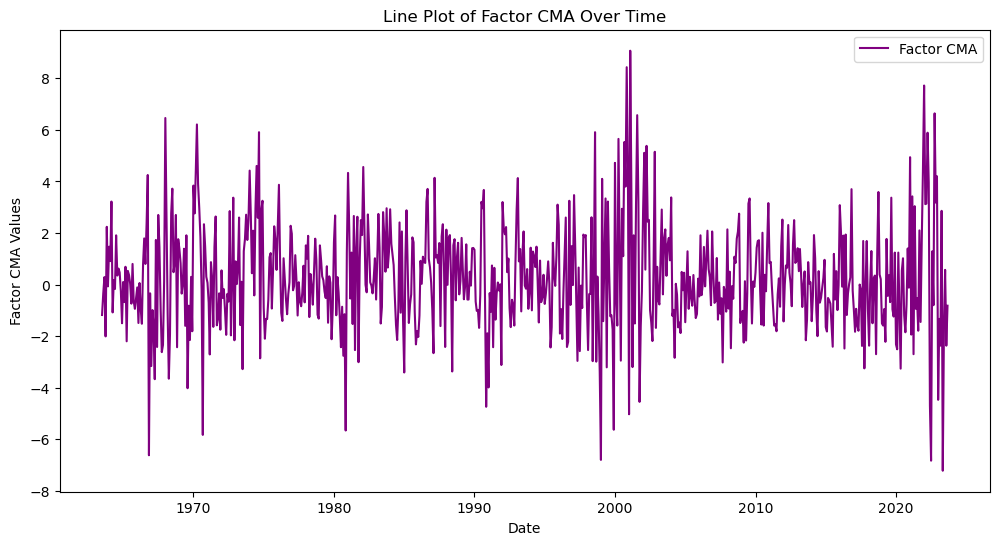

In [13]:
selected_factor = 'CMA'
plt.figure(figsize=(12, 6))
plt.plot(data.index, df_factors[selected_factor], linestyle='-', color='purple', label=f'Factor {selected_factor}')
plt.title(f'Line Plot of Factor {selected_factor} Over Time')
plt.xlabel('Date')
plt.ylabel(f'Factor {selected_factor} Values')
plt.legend()
plt.show()

#### 5. Descriptive statistics

Calculate the mean, maximum, minimum, standard deviation, skewness, kurtosis for each factor

     - for the entire sample
     - per year
     - per month

In [14]:
# Calculate the mean, maximum, minimum, standard deviation, skewness, kurtosis for the entire sample
for column_name in df_factors.columns:
    # Calculer les statistiques
    mean_value = df_factors[column_name].mean()
    max_value = df_factors[column_name].max()
    min_value = df_factors[column_name].min()
    std_deviation = df_factors[column_name].std()
    skewness = df_factors[column_name].skew()
    kurtosis = df_factors[column_name].kurtosis()

    # Afficher les résultats
    print("\n")
    print("Le facteur est:", column_name)
    print(f"Mean: {mean_value}")
    print(f"Maximum: {max_value}")
    print(f"Minimum: {min_value}")
    print(f"Standard Deviation: {std_deviation}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")



Le facteur est: Mkt-RF
Mean: 0.5558921161825726
Maximum: 16.1
Minimum: -23.24
Standard Deviation: 4.491111736025289
Skewness: -0.49871970488400186
Kurtosis: 1.7506417053654393


Le facteur est: SMB
Mean: 0.21118948824343015
Maximum: 18.28
Minimum: -15.32
Standard Deviation: 3.0233878231908053
Skewness: 0.33105075503141856
Kurtosis: 3.0646579334973354


Le facteur est: HML
Mean: 0.2835684647302905
Maximum: 12.75
Minimum: -13.87
Standard Deviation: 2.995500132438035
Skewness: 0.07537847358695504
Kurtosis: 2.3102086866175484


Le facteur est: RMW
Mean: 0.2906500691562932
Maximum: 13.07
Minimum: -18.65
Standard Deviation: 2.2195990486877557
Skewness: -0.2727235986226671
Kurtosis: 11.109857629318578


Le facteur est: CMA
Mean: 0.27432918395573996
Maximum: 9.07
Minimum: -7.22
Standard Deviation: 2.0800423997030997
Skewness: 0.26331963028230854
Kurtosis: 1.4608522009070772


The results presented are the main descriptive statistics for the 5-factor Fama-French model. Overall, we observe that the value of each factor varies around 0 with both positive and negative values, and a positive mean close to 0 for all factors.

The standard deviation is higher for the Mkt-RF, SMB and HML factors (greater than or close to 3). These three factors are therefore more subject to variation than the others. This result can be seen in the graphs presented later. Indeed, we can see graphically that the data are less centered around the mean.

For the Market Risk factor (Mkt-RF), there is a very wide distribution as shown by a standard deviation of 4.491, a high maximum of 16.1 and a low minimum of -23.24. The negative skewness of -0.499 suggests a leftward skewness in the distribution, which could mean that negative values are more extreme than positive ones even though the mean of 0.556 is positive.

The 4 other factors (SMB, HML, RMW and CMA) has average values that fluctuate between 0.2 and 0.3, with a less dispersed distribution, resulting in a lower maximum and minimum. The one with positive skewness implies a rightward skewness in the distribution. The HML factor has an almost symmetrical distribution (skewness = 0.075).

Kurtosis is used to calculate the disparity of a dataset. If it is greater than 0, then the tails are heavier than normal which indicates outliers. If Kurtosis is less than 0, then most data tend to cluster around the mean. When is equal to 0, then the tails are the same as in a normal distribution.
The Kurtosis of the RMW factor is considerably high (11.110), indicating heavy tails and potential outliers. For the 4 other factors, the statistic is also greater than 0 but relatively low. 

In [15]:
# Calculate the mean, maximum, minimum, standard deviation, skewness, kurtosis per year
stats = ["mean", "max", "min", "std", "skew"]

# Loop through each statistic
for stat in stats:
    # Calculate the statistic per year
    annual_stat = df_factors.resample('A').agg({col: stat for col in df_factors.columns})
    
    # Display the results
    print(f"These are the values of the {stat} per year:")
    print(annual_stat)
    print("\n")

#Converts the input array x into a Pandas Series
def custom_kurtosis(x):
    return pd.Series(x).kurt()

# Calculate the kurtosis per year
annual_kurtosis = df_factors.resample('A').agg(custom_kurtosis)

# Print the results
print("These are the values of the kurtosis per year:")
print(annual_kurtosis)

These are the values of the mean per year:
              Mkt-RF       SMB       HML       RMW       CMA
1963-12-31  1.103333 -1.016667  0.431667  0.441667 -0.180000
1964-12-31  0.965833  0.031667  0.730000 -0.240833  0.509167
1965-12-31  0.839167  1.705833  0.475833 -0.037500 -0.268333
1966-12-31 -1.097500  0.297500 -0.077500 -0.024167 -0.081667
1967-12-31  1.835000  3.010000 -0.331667  0.525833 -0.978333
...              ...       ...       ...       ...       ...
2019-12-31  2.133333 -0.350833 -0.663333  0.287500 -0.237500
2020-12-31  2.069167  0.527500 -2.883333 -0.175833 -0.735833
2021-12-31  1.817500 -0.093333  1.774167  1.892500  0.857500
2022-12-31 -1.770833 -0.097500  2.471667  0.720000  2.235833
2023-12-31  1.064444 -0.672222 -1.902222  0.925556 -1.863333

[61 rows x 5 columns]


These are the values of the max per year:
            Mkt-RF   SMB    HML   RMW   CMA
1963-12-31    5.07 -0.41   1.80  2.80  2.24
1964-12-31    2.69  1.23   3.40  1.07  3.22
1965-12-31    3.54  5.19  

These are the statistics for each factor per year. 

In [16]:
df = df_factors

df['Month'] = df.index.month

# Create a list of month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Loop through each month
for month in range(1, 13):
    # Filter for the current month
    month_data = df[df['Month'] == month]
    
    # Calculate statistics for the current month
    month_stats = pd.DataFrame({
        'Mean': month_data.mean(),
        'Max': month_data.max(),
        'Min': month_data.min(),
        'Std Dev': month_data.std(),
        'Kurtosis': month_data.kurtosis(),
        'Skewness': month_data.skew()
    })
    
    # Drop the 'Month' row from the resulting DataFrame
    month_stats = month_stats.drop('Month')

    # Print the results for the current month
    print(f"Statistics for {month_names[month - 1]} across all years:")
    print(month_stats, "\n")

df.drop('Month', axis=1, inplace=True)

Statistics for January across all years:
            Mean    Max    Min   Std Dev  Kurtosis  Skewness
Mkt-RF  1.085500  13.66  -8.12  5.082664 -0.174140  0.237691
SMB     1.701500  12.91  -4.38  3.820309  0.203195  0.723081
HML     1.173167  12.75 -11.29  3.977570  1.492332 -0.103376
RMW    -1.026333   4.69  -6.29  1.935758  1.032921  0.149663
CMA     0.616667   7.72  -6.80  2.724794  0.588087 -0.083055 

Statistics for February across all years:
            Mean    Max    Min   Std Dev   Kurtosis  Skewness
Mkt-RF  0.140333   7.19 -10.10  3.976442   0.131125 -0.453651
SMB     0.831667  18.28  -5.22  3.317266  12.288011  2.476812
HML     0.570333  12.47  -9.59  3.471233   2.539862  0.340687
RMW     0.028500   9.10 -18.65  3.155138  22.056923 -2.942304
CMA     0.535500   9.07  -2.66  2.265101   2.060713  1.144279 

Statistics for March across all years:
            Mean    Max    Min   Std Dev   Kurtosis  Skewness
Mkt-RF  0.721167   8.95 -13.39  3.983625   3.577330 -1.343621
SMB     0.06

We have plotted the statistics by month for all the years in our data. We note, first of all, that on average the data for January are higher than for the other months.

We also note that, overall, values vary more during the month of October. Indeed, the extreme values are greater and the standard deviation is higher overall.

Representing statistics in this way can enable us to distinguish cycles in the data. In our dataset, we don't notice any particular cycle or seasonality depending on the month, even if some values are higher than others.

#### 6. Correlation matrix
1. Estimate the factor correlation matrix and comment
2. Make a graphical representation of this matrix
3. Check the significance of the correlation between the factors $HML$ and $SMB$

In [17]:
# Calculate the factor correlation matrix
factor_corr_matrix = df_factors.corr()

# Display the factor correlation matrix
print("Factor Correlation Matrix:")
print(factor_corr_matrix)

Factor Correlation Matrix:
          Mkt-RF       SMB       HML       RMW       CMA
Mkt-RF  1.000000  0.280470 -0.209185 -0.180923 -0.361115
SMB     0.280470  1.000000 -0.014685 -0.352044 -0.093437
HML    -0.209185 -0.014685  1.000000  0.088654  0.686378
RMW    -0.180923 -0.352044  0.088654  1.000000 -0.012526
CMA    -0.361115 -0.093437  0.686378 -0.012526  1.000000


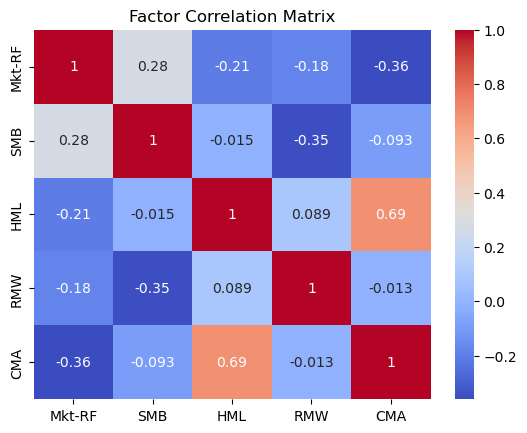

In [18]:
sns.heatmap(factor_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Factor Correlation Matrix')
plt.show()

In [19]:
from scipy import stats

cor, pvalue = stats.pearsonr(df_factors['HML'].to_numpy(),
               df_factors['SMB'].to_numpy())
print("The correlation between HML and SMB is", cor, ".\n")
print("The pvalue of the correlation is", pvalue, ".\n")

step = 0.5
if pvalue < step:
    print("Correlation between HML and SMB is significant.")
else:
    print("The correlation between HML and SMB is not significant.")

The correlation between HML and SMB is -0.014685362771230656 .

The pvalue of the correlation is 0.6934276738266496 .

The correlation between HML and SMB is not significant.


The factors CMA and HML are highly correlated with a correlation coefficient of 0.69. These 2 factors reflect different aspects of corporate behavior. HML is associated with differences in valuation (book-to-market ratio), while CMA is linked to differences in investment policies. The correlation indicates that companies with high book-to-market ratio, considered as undervalued by the market, are likely to adopt conservative investment strategies. 
It could be the sign that these factors are redundant since the HML values are highly explained by the other factor (and vice-versa).

The CMA and Market Risk factors are negatively correlated (-0.36) because of different economic cycle sensitivity and investor behavior. In times of uncertainty, conservative investment strategies may be favored, while times of stability can favorize market risk. 

The negative correlation between SMB and RMW factors is also consistent and indicates that the stocks with low profitability are more likely to be the stocks of smaller companies.


## II. The 25 portfolios formed from Size and OP

We import the returns of 25 portfolios formed from NYSE, AMEX and NASDAQ securities for which we have all the quotations.
These shares are divided into 25 portfolios obtained by crossing the *Size*
- divided into 5 categories of SMALL or ME1/ME2/ME3/ME4/BIG or ME5

and the ratio *OP* : Operating Profitability
 
- divided into 5 categories of LoOP or OP1/OP2/OP3/OP4/HiOP or OP5

This data can be found in the file "25_Portfolios_ME_OP_5x5_Wout_Div.CSV"

#### 1. Data import

1. Import the data
2. Transform the dates into yyyy-mm-01 format (example 196307 becomes 1963-07-01)
3. Transform dates into indices

In [20]:
column_names = ['datetime','SMALL LoOP','ME1 OP2', 'ME1 OP3','ME1 OP4',
               'SMALL HiOP','ME2 OP1', 'ME2 OP2', 'ME2 OP3','ME2 OP4','ME2 OP5',
               'ME3 OP1', 'ME3 OP2', 'ME3 OP3','ME3 OP4','ME3 OP5',
               'ME4 OP1', 'ME4 OP2', 'ME4 OP3','ME4 OP4','ME4 OP5',
               'BIG LoOP','ME5 OP2','ME5 OP3','ME5 OP4','BIG HiOP']

data_25_Portfolio = pd.read_csv('/Users/nathanliesse/Documents/bureau/FAC/M1/S1/info - python/Project_GroupRenzhiLIU/25_Portfolios_ME_OP_5x5_Wout_Div.csv',
                header=None,
                names = column_names,
                skiprows=23,
                encoding='latin1',
                nrows = 723)

print(data_25_Portfolio)

     datetime  SMALL LoOP  ME1 OP2  ME1 OP3  ME1 OP4  SMALL HiOP  ME2 OP1  \
0      196307     -0.6705   1.2181   2.4664  -0.9614     -1.1993  -1.2551   
1      196308      2.1994   3.6919   2.2153   2.3272      4.0410   6.2016   
2      196309     -1.5825  -1.1712  -2.2143   4.0691     -1.6038  -1.9994   
3      196310      0.1584  -1.0551   1.1348   3.0337      0.2181   3.5349   
4      196311     -2.3473  -1.7879  -3.6168  -2.6146     -3.3887  -1.6161   
..        ...         ...      ...      ...      ...         ...      ...   
718    202305      2.8277  -2.1309  -0.2376  -1.8709     -0.3256   3.3698   
719    202306      3.1023   9.3744   7.5732   9.8428      9.8191   6.4446   
720    202307      4.5380   7.3617   9.4589   8.3435      8.6348   5.3241   
721    202308    -10.9330  -3.9924  -5.8769  -6.7043     -6.1876  -8.3390   
722    202309     -9.0552  -4.6907  -4.9288  -4.8163     -1.7269  -9.1260   

     ME2 OP2  ME2 OP3  ME2 OP4  ...  ME4 OP1  ME4 OP2  ME4 OP3  ME4 OP4  \


In [ ]:
data_25_Portfolio.info()

In [21]:
#Transform dates into dataframe index
data_25_Portfolio['datetime'] = pd.to_datetime(data_25_Portfolio['datetime'], format='%Y%m')

data_25_Portfolio.set_index('datetime', inplace=True)
data_25_Portfolio.index.name = None
data_25_Portfolio.head()

,SMALL LoOP,ME1 OP2,ME1 OP3,ME1 OP4,SMALL HiOP,ME2 OP1,ME2 OP2,ME2 OP3,ME2 OP4,ME2 OP5,...,ME4 OP1,ME4 OP2,ME4 OP3,ME4 OP4,ME4 OP5,BIG LoOP,ME5 OP2,ME5 OP3,ME5 OP4,BIG HiOP
1963-07-01,-0.6705,1.2181,2.4664,-0.9614,-1.1993,-1.2551,-2.1457,-1.1506,0.6419,0.3073,...,-3.6017,-0.6540,-2.1827,-1.4483,-0.0358,0.2036,1.3578,-0.0689,-1.1041,0.6455
1963-08-01,2.1994,3.6919,2.2153,2.3272,4.0410,6.2016,5.4030,3.4699,4.6566,3.5437,...,4.8709,4.9670,5.9343,4.1942,6.2595,4.1981,3.6953,4.7542,5.3736,5.4765
1963-09-01,-1.5825,-1.1712,-2.2143,4.0691,-1.6038,-1.9994,-1.9601,-0.0890,-2.5102,-4.2698,...,-1.9026,-1.4033,-2.5062,-3.0080,-2.4167,-2.5485,-2.3196,0.8222,-2.0080,-1.3054
1963-10-01,0.1584,-1.0551,1.1348,3.0337,0.2181,3.5349,2.9549,1.0929,-1.4399,4.6419,...,2.9412,0.2448,1.6633,-0.8305,2.9515,-0.1189,-0.1349,2.2829,2.9912,7.7337
1963-11-01,-2.3473,-1.7879,-3.6168,-2.6146,-3.3887,-1.6161,-0.7255,-0.3999,-1.6184,-2.3957,...,-0.5446,-1.5143,-0.5209,-0.7213,0.3579,-1.6703,-1.8024,0.7283,0.3042,-3.8383


#### 2. Calculate the excess returns $R_{it} -RF_{t}$

In [22]:
#Initialize a new DataFrame for excess returns
df_excess_returns = pd.DataFrame(index=data_25_Portfolio.index)

#Calculate excess returns for each asset and add to the new DataFrame
for column in data_25_Portfolio.columns:
    asset_name = column
    df_excess_returns[f'{asset_name}'] = data_25_Portfolio[column] - df_risk_free['RF']

#Display the new DataFrame with excess returns
print(df_excess_returns)

rows_df_excess_returns, columns_df_excess_returns = df_excess_returns.shape


            SMALL LoOP  ME1 OP2  ME1 OP3  ME1 OP4  SMALL HiOP  ME2 OP1  \
1963-07-01     -0.9405   0.9481   2.1964  -1.2314     -1.4693  -1.5251   
1963-08-01      1.9494   3.4419   1.9653   2.0772      3.7910   5.9516   
1963-09-01     -1.8525  -1.4412  -2.4843   3.7991     -1.8738  -2.2694   
1963-10-01     -0.1316  -1.3451   0.8448   2.7437     -0.0719   3.2449   
1963-11-01     -2.6173  -2.0579  -3.8868  -2.8846     -3.6587  -1.8861   
...                ...      ...      ...      ...         ...      ...   
2023-05-01      2.4677  -2.4909  -0.5976  -2.2309     -0.6856   3.0098   
2023-06-01      2.7023   8.9744   7.1732   9.4428      9.4191   6.0446   
2023-07-01      4.0880   6.9117   9.0089   7.8935      8.1848   4.8741   
2023-08-01    -11.3830  -4.4424  -6.3269  -7.1543     -6.6376  -8.7890   
2023-09-01     -9.4852  -5.1207  -5.3588  -5.2463     -2.1569  -9.5560   

            ME2 OP2  ME2 OP3  ME2 OP4  ME2 OP5  ...  ME4 OP1  ME4 OP2  \
1963-07-01  -2.4157  -1.4206   0.3719 

#### 3. Calculation of descriptive statistics

Calculate the average returns for each portfolio. What can you say about the relationship between average yield and
- the *Size* ?
- the *OP* ?

In [23]:
average_returns = data_25_Portfolio.mean(axis=0)

# Create a new DataFrame for average returns
df_average_returns = pd.DataFrame({'Average Returns': average_returns})

#Displays the results
df_average_returns


,Average Returns
SMALL LoOP,0.805521
ME1 OP2,1.133213
ME1 OP3,1.063341
ME1 OP4,1.215467
SMALL HiOP,1.073039
ME2 OP1,0.831554
ME2 OP2,0.948523
ME2 OP3,0.964448
ME2 OP4,0.984684
ME2 OP5,1.175385


First of all, with the Size, we can find a trend where, on average, returns are decreasing as the size of the portfolios increases. That is, small portfolio tend to have higher average returns compared to big portfolios.

Concerning the Operating Profitability effect, portfoilios with higher operating profitability (HiOP or OP5) generally have higher average returns compared to portfolios with lower operating profitability (LoOP or OP1). 

Overall, we see that smaller companies have higher average yield. This may be due to higher growth potential: smaller companies are more flexible, they can react quickly to economic changes, have a high potential for innovation and often have lower fixed costs which contributes to higher profitability.

For a given size (from ME1 to ME5), returns of the portfolios increase with operating profitability. Higher operating profitability reflects strong management and efficiency of the company's activities: profitable companies attract investors buy generating more value, which contributes to higher returns through optimal financial performance.

Therefore, the portfolio with the lower average return is the BIG LoOP with low operating profit and big size. The portfolios with small companies (M1) have the highest returns. 


## III. Estimation of the factor model


For each asset *i*, we have T observations ${r_{i1},...,r_{iT}}$. We can estimate the following three regressions:
    
### Regression on the market factor
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+e_{it}$$

### Regression on the 3 factors
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+s_{i}SMB_{t}+h_{i}HML_{ t}+e_{it}$$

### Regression on the 5 factors
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+s_{i}SMB_{t}+h_{i}HML_{ t}+r_{i}RMW_{t}+c_{i}CMA_{t}+e_{it}$$

- $R_{Ft}$ is the risk-free rate
- $R_{MT}$ is the market portfolio rate of return
- The residual $e_{it}$ represents the idiosyncratic risk (or diversifiable risk) of each asset.
- $\beta_{i}, s_{i}, h_{i},r_{i}, c_{i}$ represent the exposures to each of the factors
- $\alpha_{i}$ is the constant. According to efficient portfolio theory, we expect to have $a_{i}=0$. This hypothesis can also be justified by the proposition that all the factors represent all the risk factors.

#### 1. Construct a function to estimate these three regressions. You will keep as output:

1. the estimated coefficients
2. the tstat of the estimated coefficients
3. the residuals of the regressions
4. The average of constants in absolute value

In [24]:
def results_regressions(df_excess_returns, data):
    
    #Initialization of the constante to 0 for all the regressions
    cst_1factor = 0
    cst_3factors = 0
    cst_5factors = 0
    
    #Creation of the dataframes for all the regressions
    results_1factor = pd.DataFrame(index=['constant', 'tstats_cst','beta_Mkt-RF','tstats_Mkt-RF'], columns=df_excess_returns.columns)
    results_3factors = pd.DataFrame(index = ['constant','tsats_cst','beta_Mkt-RF','tstats_Mkt-RF','beta_SMB','tstats_SMB','beta_HML','tstats_HML'], columns = df_excess_returns.columns)
    results_5factors = pd.DataFrame(index=['constant','tsats_cst','beta_Mkt-RF','tstats_Mkt-RF','beta_SMB','tstats_SMB','beta_HML','tstats_HML','beta_RMW','tstats_RMW','beta_CMA','tstats_CMA'], columns = df_excess_returns.columns)
    
    #Creation of the dataframes for all the resid value
    resid_1factor = pd.DataFrame(index=df_excess_returns.index, columns=df_excess_returns.columns)
    resid_3factors = pd.DataFrame(index=df_excess_returns.index, columns=df_excess_returns.columns)
    resid_5factors = pd.DataFrame(index=df_excess_returns.index, columns=df_excess_returns.columns)
    
    #Creation of the dependent varibale (y) and the independent one (x)
    for asset in df_excess_returns.columns :
        y = df_excess_returns[asset]
        X_1factor = sm.add_constant(data['Mkt-RF'])
        
        #Regression for the one factor model
        model_1factor = sm.OLS(y, X_1factor).fit()
        
        #Print the one factor regression results
        results_1factor.loc['constant',asset] = model_1factor.params['const']
        results_1factor.loc['tstats_cst',asset] = model_1factor.tvalues['const']
        results_1factor.loc['beta_Mkt-RF',asset] = model_1factor.params['Mkt-RF']
        results_1factor.loc['tstats_Mkt-RF',asset] = model_1factor.tvalues['Mkt-RF']
        
        for j in resid_1factor.index:
            resid_1factor.loc[j, asset] = model_1factor.resid[j]
            
        cst_1factor += np.abs(model_1factor.params['const'])
        
        #Regression for the three factors model
        X_3factors = sm.add_constant(data[['Mkt-RF','SMB','HML']])
        model_3factors = sm.OLS(y,X_3factors).fit()
        
        #Print the 3 factor regression results
        results_3factors.loc['constant',asset] = model_3factors.params['const']
        results_3factors.loc['tstats_cst', asset] = model_3factors.tvalues['const']
        results_3factors.loc['beta_Mkt-RF',asset] = model_3factors.params['Mkt-RF']
        results_3factors.loc['tstats_Mkt-RF',asset] = model_3factors.tvalues['Mkt-RF']
        results_3factors.loc['beta_SMB', asset] = model_3factors.params['SMB']
        results_3factors.loc['tstats_SMB',asset] = model_3factors.tvalues['SMB']
        results_3factors.loc['beta_HML',asset] = model_3factors.params['HML']
        results_3factors.loc['tstats_HML',asset] = model_3factors.tvalues['HML']
    
        for j in resid_3factors.index:
            resid_3factors.loc[j, asset] = model_3factors.resid[j]

        cst_3factors += np.abs(model_3factors.params['const'])
        
        #Regression for the five factors model
        X_5factors = sm.add_constant(data[['Mkt-RF','SMB','HML','RMW','CMA']])
        model_5factors = sm.OLS(y,X_5factors).fit()

        
        #Print the five factor regression results
        results_5factors.loc['constant',asset] = model_5factors.params['const']
        results_5factors.loc['tstats_cst',asset] = model_5factors.tvalues['const']
        results_5factors.loc['beta_Mkt-RF',asset] = model_5factors.params['Mkt-RF']
        results_5factors.loc['tstats_Mkt-RF',asset] = model_5factors.tvalues['Mkt-RF']
        results_5factors.loc['beta_SMB', asset] = model_5factors.params['SMB']
        results_5factors.loc['tstats_SMB',asset] = model_5factors.tvalues['SMB']
        results_5factors.loc['pvalue_SMB', asset] = model_5factors.pvalues['SMB']        
        results_5factors.loc['beta_HML',asset] = model_5factors.params['HML']
        results_5factors.loc['tstats_HML', asset] = model_5factors.tvalues['HML']
        results_5factors.loc['pvalue_HML', asset] = model_5factors.pvalues['HML']
        results_5factors.loc['beta_RMW', asset] = model_5factors.params['RMW']
        results_5factors.loc['tstats_RMW', asset] = model_5factors.tvalues['RMW']
        results_5factors.loc['pvalue_RMW', asset] = model_5factors.pvalues['RMW']
        results_5factors.loc['beta_CMA', asset] = model_5factors.params['CMA']
        results_5factors.loc['tstats_CMA', asset] = model_5factors.tvalues['CMA']
        results_5factors.loc['pvalue_CMA', asset] = model_5factors.pvalues['CMA']
        
        for j in resid_5factors.index:
            resid_5factors.loc[j, asset] = model_5factors.resid[j]

        cst_5factors += np.abs(model_5factors.params['const'])

    rows_df_excess_returns, columns_df_excess_returns = df_excess_returns.shape

    mean_cst_abs_1factor = cst_1factor / columns_df_excess_returns
    mean_cst_abs_3factors = cst_3factors / columns_df_excess_returns
    mean_cst_abs_5factors = cst_5factors / columns_df_excess_returns
    
    return results_1factor, mean_cst_abs_1factor, resid_1factor, results_3factors, mean_cst_abs_3factors, resid_3factors, results_5factors, mean_cst_abs_5factors, resid_5factors
        

We create a new dataframe thanks to a function in order to have the right time range of values.

In [25]:
def df_bfr_date(df, end_date):
    new_df = df[df.index <= end_date]
    return new_df
    
#Creation of the dataframe for the datetime wanted : 1963-07-01 to 2023-07-01
end_date = '2023-07-01'

df_excess_returns_2 = df_bfr_date(df_excess_returns, end_date)
df_factors_2 = df_bfr_date(df_factors, end_date)

In [26]:
results_1factor, mean_cst_abs_1factor, resid_1factor, results_3factors, mean_cst_abs_3factors, resid_3factors, results_5factors, mean_cst_abs_5factors, resid_5factors = results_regressions(df_excess_returns_2, df_factors_2)


We can print the results of our regressions, just below. 

In [27]:
print("Results of the one factor regression are :")
print(results_1factor)

Results of the one factor regression are :
              SMALL LoOP    ME1 OP2    ME1 OP3    ME1 OP4 SMALL HiOP  \
constant       -0.246453   0.187713   0.132683   0.259066   0.001187   
tstats_cst     -1.421251   1.407424   1.075763   1.361532   0.008225   
beta_Mkt-RF     1.267159   1.053706   1.032418   1.080229    1.27398   
tstats_Mkt-RF  33.055304  35.737407  37.864295  25.680729  39.920085   

                 ME2 OP1    ME2 OP2    ME2 OP3   ME2 OP4   ME2 OP5  ...  \
constant        -0.26314  -0.029669     0.0297  0.006135  0.108362  ...   
tstats_cst     -1.921638  -0.279584   0.291625  0.056274  0.894921  ...   
beta_Mkt-RF     1.336336   1.120415   1.036788  1.111515   1.24956  ...   
tstats_Mkt-RF  44.144129  47.759367  46.050464  46.12227  46.68096  ...   

                 ME4 OP1    ME4 OP2    ME4 OP3    ME4 OP4    ME4 OP5  \
constant       -0.292839  -0.162119   -0.09502  -0.047421    0.00919   
tstats_cst     -2.756505  -2.266344  -1.429123  -0.692718   0.121784   
beta

In [28]:
print("Residuals of the one factor model regression:")
print(resid_1factor)

Residuals of the one factor model regression:
           SMALL LoOP    ME1 OP2    ME1 OP3    ME1 OP4 SMALL HiOP   ME2 OP1  \
1963-07-01  -0.199855   1.171332    2.46636  -1.069176  -0.973635 -0.740789   
1963-08-01  -4.228644  -2.088105  -3.401744  -3.658628  -2.669266 -0.560482   
1963-09-01   0.383393   0.025406  -0.996086   5.235994   0.125161  0.091788   
1963-10-01   -3.09106  -4.198691  -1.899902  -0.248346  -3.296257  0.127111   
1963-11-01  -1.293762  -1.349963  -3.141928  -2.225471  -2.577004 -0.487074   
...               ...        ...        ...        ...        ...       ...   
2023-03-01 -10.773917 -12.577616 -12.096953 -10.904041 -14.930477 -8.464762   
2023-04-01  -1.226814  -5.672974  -6.247158  -5.993805  -2.426915 -1.392124   
2023-05-01   2.270647  -3.047411   -1.09163  -2.868046   -1.13268  2.805223   
2023-06-01  -5.237096   1.979743   0.371094   2.205453   1.188002 -2.324988   
2023-07-01   0.266872   3.341589   5.562154   4.166898   4.094137  0.847603   

     

In [29]:
print("Results of the three factor regression are :")
print(results_3factors)

Results of the three factor regression are :
              SMALL LoOP    ME1 OP2    ME1 OP3    ME1 OP4 SMALL HiOP  \
constant       -0.357997  -0.033794  -0.092458   0.020834  -0.188551   
tsats_cst            NaN        NaN        NaN        NaN        NaN   
beta_Mkt-RF     0.988587   0.895872   0.906737   0.933828   1.090766   
tstats_Mkt-RF  49.863668  65.831875  65.207786   26.78688  61.685245   
beta_SMB        1.390992   1.051675    0.91861   1.030051   1.108592   
tstats_SMB      48.29603  53.197238  45.474374  20.339081  43.155746   
beta_HML       -0.124401   0.283753   0.335053   0.336527   0.178594   
tstats_HML     -4.362821  14.497916  16.753524   6.711967   7.022477   
tstats_cst     -4.220905  -0.580471  -1.554244   0.139697  -2.492499   

                 ME2 OP1    ME2 OP2    ME2 OP3    ME2 OP4    ME2 OP5  ...  \
constant        -0.31897  -0.206851  -0.152674  -0.166875  -0.051607  ...   
tsats_cst            NaN        NaN        NaN        NaN        NaN  ...   
bet

In [30]:
print('Residuals of the three factor regressions are :')
print(resid_3factors)

Residuals of the three factor regressions are :
           SMALL LoOP   ME1 OP2   ME1 OP3   ME1 OP4 SMALL HiOP   ME2 OP1  \
1963-07-01   0.252684  2.037711  3.344117 -0.139288  -0.227592 -0.507518   
1963-08-01  -1.368021 -0.735793 -2.407606 -2.459851  -0.985228  1.778838   
1963-09-01   0.797066  0.509095 -0.534144  5.736254   0.580504  0.369662   
1963-10-01  -0.353688 -2.087659 -0.046413  1.825705  -1.084185  2.194342   
1963-11-01   0.022771  -0.83371 -2.801582 -1.794158  -1.879976   0.61179   
...               ...       ...       ...       ...        ...       ...   
2023-03-01  -1.410618 -2.150103 -2.215973 -0.171518  -5.006688 -2.066049   
2023-04-01   2.610623  -2.65155 -3.580307 -3.015877   0.719723  1.492857   
2023-05-01   2.047894 -0.180449  2.113184  0.410837   0.921192  1.999864   
2023-06-01  -5.222245  1.885393  0.264313  2.096665   1.122224  -2.29159   
2023-07-01  -2.194315 -0.104272  2.186437  0.546003   0.967399 -0.686523   

             ME2 OP2   ME2 OP3   ME2 OP

In [31]:
print("Results of the five factor regression are :")
print(results_5factors)

Results of the five factor regression are :
              SMALL LoOP    ME1 OP2    ME1 OP3    ME1 OP4 SMALL HiOP  \
constant       -0.165906  -0.073791  -0.192985  -0.170248  -0.294839   
tsats_cst            NaN        NaN        NaN        NaN        NaN   
beta_Mkt-RF     0.976294   0.898485    0.91949   0.978603   1.094374   
tstats_Mkt-RF  57.722915  63.614281  67.190726  27.185645  64.000385   
beta_SMB        1.242754   1.082453   0.985624   1.123109   1.195953   
tstats_SMB     50.243096   52.40548  49.248968  21.334309  47.824948   
beta_HML       -0.135747   0.285846   0.308829    0.18219   0.201122   
tstats_HML     -4.290417  10.818743  12.063721   2.705569    6.28748   
beta_RMW       -0.621361   0.128967   0.275937    0.36453   0.368689   
tstats_RMW    -18.652185   4.635971  10.237415   5.141435  10.947022   
beta_CMA        0.097144  -0.019571   0.027301   0.305755  -0.093231   
tstats_CMA      2.028592  -0.489394   0.704619    2.99998  -1.925693   
tstats_cst      -2.3

In [32]:
print('Residuals of the five factor regressions are :')
print(resid_5factors)

Residuals of the five factor regressions are :
           SMALL LoOP   ME1 OP2   ME1 OP3   ME1 OP4 SMALL HiOP   ME2 OP1  \
1963-07-01    0.52117  1.982585  3.296235  0.070614  -0.422947 -0.301643   
1963-08-01  -1.338269 -0.741463 -2.360705 -2.167742  -1.033253  1.759928   
1963-09-01   0.040729  0.666169 -0.187341  6.236235   1.023763  -0.37966   
1963-10-01   1.213203 -2.411725 -0.605373  1.611307  -2.083065  3.619221   
1963-11-01   -0.82486 -0.658457 -2.505776 -1.712017  -1.336299 -0.153765   
...               ...       ...       ...       ...        ...       ...   
2023-03-01  -1.078964 -2.219819 -2.467867 -0.904795  -5.150624 -1.657694   
2023-04-01   3.271947   -2.7904 -4.062902 -4.376676   0.422766  2.291392   
2023-05-01   1.292898 -0.021388  2.728819  2.297478   1.227531  1.036526   
2023-06-01  -3.627301  1.554963 -0.371476  1.534322   0.139221 -0.787796   
2023-07-01  -2.285902 -0.084617  2.303874   0.99504   0.982959 -0.837555   

             ME2 OP2   ME2 OP3   ME2 OP4

#### 2. Estimate coefficient
1. Calculate and give the names of the portfolios for which the market portfolio return coefficient is

- greater than 1
- equal to 1
- less than 1

2. For each of the HML, SMB and CMA factors, give:
    
- the number of assets for which each of the factors taken one by one is not significant
- the names of the portfolio concerned

Which factors do not seem to you to have any explanatory power in the variations in yields?

In [33]:
return_coeff_greater_1 = []
return_coeff_equal_1 = []
return_coeff_less_1 = []

for asset in df_excess_returns.columns:
    if results_1factor.loc['beta_Mkt-RF', asset] > 1:
        return_coeff_greater_1.append(asset)
    elif results_1factor.loc['beta_Mkt-RF', asset] < 1:
        return_coeff_less_1.append(asset)
    else:
        return_coeff_equal_1.append(asset)
        
print(f"The names of the portfolios for which the market portfolio return coefficient is greater than 1 are {return_coeff_greater_1} \n")
print(f"The names of the portfolios for which the market portfolio return coefficient is equal to 1 are {return_coeff_equal_1} \n")
print(f"The names of the portfolios for which the market portfolio return coefficient is less than 1 are {return_coeff_less_1}")

The names of the portfolios for which the market portfolio return coefficient is greater than 1 are ['SMALL LoOP', 'ME1 OP2', 'ME1 OP3', 'ME1 OP4', 'SMALL HiOP', 'ME2 OP1', 'ME2 OP2', 'ME2 OP3', 'ME2 OP4', 'ME2 OP5', 'ME3 OP1', 'ME3 OP2', 'ME3 OP3', 'ME3 OP4', 'ME3 OP5', 'ME4 OP1', 'ME4 OP2', 'ME4 OP3', 'ME4 OP4', 'ME4 OP5', 'BIG LoOP'] 

The names of the portfolios for which the market portfolio return coefficient is equal to 1 are [] 

The names of the portfolios for which the market portfolio return coefficient is less than 1 are ['ME5 OP2', 'ME5 OP3', 'ME5 OP4', 'BIG HiOP']


It is interesting to notice that the only portfolios for which the market portfolio return coefficient is less than 1 are the ones of big size ME5. 

The beta_market measures the sensitivity of a portfolio's returns to the overall market returns so when beta_market < 1, the portfolio is expected to be less volatile than the market. 
Larger companies are more established and often have lower betas. This is because they have more stable cash flows, lower risk: investors perceive larger companies as less risky, which translates into lower beta values.

Smaller companies often have higher beta values because they have more uncertain cash flows, are more sensitive to economic conditions, making them more volatile.

In [34]:
num_asset_HML = 0
num_asset_SMB = 0
num_asset_CMA = 0

asset_HML = []
asset_SMB = []
asset_CMA = []

for asset in df_excess_returns.columns : 
    if np.abs(results_5factors.loc['pvalue_HML',asset]) > 0.05 :
        num_asset_HML += 1
        asset_HML.append(asset) 
        
    elif np.abs(results_5factors.loc['pvalue_SMB',asset]) > 0.05 :
        num_asset_SMB += 1
        asset_SMB.append(asset) 
        
    elif np.abs(results_5factors.loc['pvalue_CMA',asset]) > 0.05 :
        num_asset_CMA += 1
        asset_CMA.append(asset) 
        
print(f"The number of assets for which HML is not significant is {num_asset_HML} and the portfolio concerned are {asset_HML} \n")
print(f"The number of assets for which SMB is not significant is {num_asset_SMB} and the portfolio concerned are {asset_SMB} \n")
print(f"The number of assets for which CMA is not significant is {num_asset_CMA} and the portfolio concerned are {asset_CMA}")


The number of assets for which HML is not significant is 3 and the portfolio concerned are ['ME4 OP1', 'ME4 OP5', 'ME5 OP4'] 

The number of assets for which SMB is not significant is 0 and the portfolio concerned are [] 

The number of assets for which CMA is not significant is 13 and the portfolio concerned are ['ME1 OP2', 'ME1 OP3', 'SMALL HiOP', 'ME2 OP1', 'ME2 OP2', 'ME2 OP3', 'ME3 OP2', 'ME3 OP3', 'ME3 OP4', 'ME4 OP2', 'ME4 OP3', 'ME5 OP3', 'BIG HiOP']


CMA appears as being the less significant factor. Variations in Conservative Minus Aggressive components do not significantly correlate with the returns for half of the portfolios. 

#### 3. Correlation of residuals

1. Calculate the correlation matrix of residuals and make its graphic visualization
2. Can we assume that the correlations of the residuals are zero on average? What can you infer about the ability of the five factors to explain common variations in returns?

The correlation matrix of residuals for the one factor model is:             SMALL LoOP   ME1 OP2   ME1 OP3   ME1 OP4  SMALL HiOP   ME2 OP1  \
SMALL LoOP    1.000000  0.760059  0.668772  0.518873    0.713695  0.845709   
ME1 OP2       0.760059  1.000000  0.903356  0.612127    0.827637  0.648050   
ME1 OP3       0.668772  0.903356  1.000000  0.654250    0.841275  0.582765   
ME1 OP4       0.518873  0.612127  0.654250  1.000000    0.634273  0.452799   
SMALL HiOP    0.713695  0.827637  0.841275  0.634273    1.000000  0.602184   
ME2 OP1       0.845709  0.648050  0.582765  0.452799    0.602184  1.000000   
ME2 OP2       0.648839  0.816737  0.810087  0.548899    0.734102  0.635549   
ME2 OP3       0.582495  0.787039  0.808997  0.566685    0.737938  0.584197   
ME2 OP4       0.547055  0.765251  0.765914  0.513737    0.738949  0.527111   
ME2 OP5       0.541264  0.729411  0.748451  0.521080    0.787922  0.515251   
ME3 OP1       0.704068  0.458034  0.369661  0.288494    0.422597  0.781259   

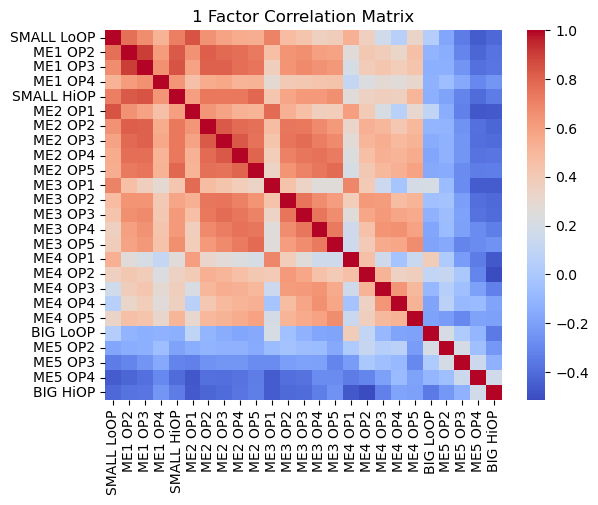


Mean correlation between residuals : 0.2867353618898324


In [35]:
resid_1factor_corr_matrix = resid_1factor.corr()
print("The correlation matrix of residuals for the one factor model is:", resid_1factor_corr_matrix)

sns.heatmap(resid_1factor_corr_matrix, annot=False, cmap='coolwarm')
plt.title('1 Factor Correlation Matrix')
plt.show()

mean_corr = resid_1factor_corr_matrix.mean().mean()
print("\nMean correlation between residuals :",mean_corr)

The correlation matrix of residuals for the three factor model is:
            SMALL LoOP   ME1 OP2   ME1 OP3   ME1 OP4  SMALL HiOP   ME2 OP1  \
SMALL LoOP    1.000000  0.095147 -0.117869  0.032065   -0.042456  0.418573   
ME1 OP2       0.095147  1.000000  0.552203  0.133010    0.271861 -0.195905   
ME1 OP3      -0.117869  0.552203  1.000000  0.272145    0.417543 -0.251617   
ME1 OP4       0.032065  0.133010  0.272145  1.000000    0.253139 -0.047632   
SMALL HiOP   -0.042456  0.271861  0.417543  0.253139    1.000000 -0.296790   
ME2 OP1       0.418573 -0.195905 -0.251617 -0.047632   -0.296790  1.000000   
ME2 OP2      -0.281802  0.124306  0.178218 -0.010118   -0.040350 -0.126158   
ME2 OP3      -0.485298  0.002848  0.175969  0.041687    0.007994 -0.246689   
ME2 OP4      -0.510430  0.044381  0.122614 -0.031961    0.100955 -0.379783   
ME2 OP5      -0.425367  0.052663  0.198072  0.049256    0.345870 -0.346226   
ME3 OP1       0.295747 -0.300335 -0.411379 -0.153660   -0.337101  0.509904 

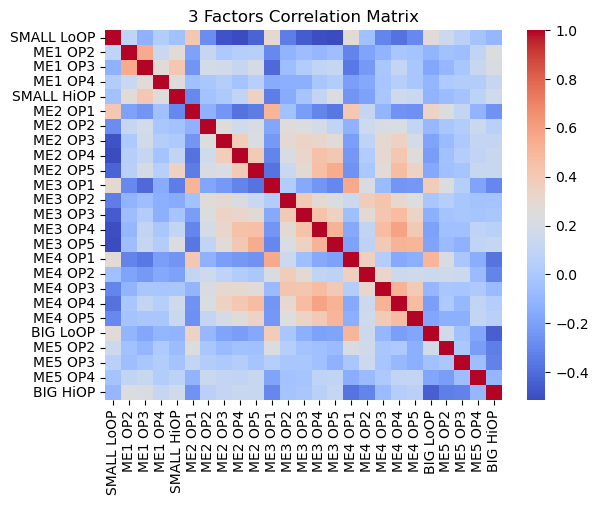


Mean correlation between residuals : 0.07407620485303398


In [36]:
resid_3factors_corr_matrix = resid_3factors.corr()
print("The correlation matrix of residuals for the three factor model is:")
print(resid_3factors_corr_matrix)

sns.heatmap(resid_3factors_corr_matrix, annot=False, cmap='coolwarm')
plt.title('3 Factors Correlation Matrix')
plt.show()

mean_corr = resid_3factors_corr_matrix.mean().mean()
print("\nMean correlation between residuals :",mean_corr)

The correlation matrix of residuals for the five factor model is:
            SMALL LoOP   ME1 OP2   ME1 OP3   ME1 OP4  SMALL HiOP   ME2 OP1  \
SMALL LoOP    1.000000  0.250722  0.119695  0.158476    0.258535  0.059777   
ME1 OP2       0.250722  1.000000  0.532792  0.108678    0.222887 -0.107751   
ME1 OP3       0.119695  0.532792  1.000000  0.227661    0.324911 -0.027021   
ME1 OP4       0.158476  0.108678  0.227661  1.000000    0.214941  0.081583   
SMALL HiOP    0.258535  0.222887  0.324911  0.214941    1.000000 -0.056096   
ME2 OP1       0.059777 -0.107751 -0.027021  0.081583   -0.056096  1.000000   
ME2 OP2      -0.230395  0.097676  0.124211 -0.048682   -0.116824 -0.018782   
ME2 OP3      -0.372714 -0.063499  0.056980 -0.023148   -0.149065 -0.028040   
ME2 OP4      -0.303353 -0.054366 -0.069971 -0.130350   -0.129832 -0.076709   
ME2 OP5      -0.116901 -0.066874 -0.013502 -0.051557    0.146948  0.062734   
ME3 OP1      -0.156933 -0.251553 -0.245108 -0.043967   -0.113095  0.133078  

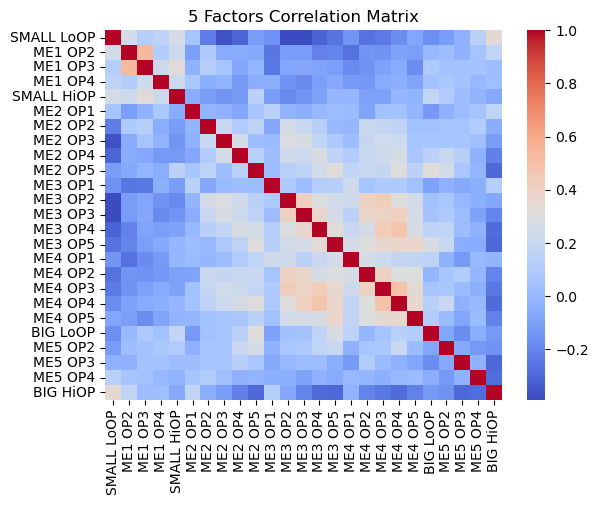


Mean correlation between residuals : 0.08269248277249627


In [37]:
resid_5factors_corr_matrix = resid_5factors.corr()
print("The correlation matrix of residuals for the five factor model is:")
print(resid_5factors_corr_matrix)

sns.heatmap(resid_5factors_corr_matrix, annot=False, cmap='coolwarm')
plt.title('5 Factors Correlation Matrix')
plt.show()

mean_corr = resid_5factors_corr_matrix.mean().mean()
print("\nMean correlation between residuals :",mean_corr)

Positive values in the correlation matrix indicate that the residuals move in the same direction: it suggests that when one portfolio outperforms its expected return (residuals are positive), the other portfolio is also more likely to outperform its expected return. Negative correlations suggest an inverse relationship between the residuals of the corresponding portfolios: when one portfolio does better than expected the other portfolio is more likely to do worse than expected.

For the one factor model, we can globally observe the tendency for small companies to have positive correlations of residuals with other companies and for big companies to have negative correlations of residuals. An explanation linked with the 1 factor model would be that small companies have higher beta values and are therefore more sensitive to market movements, leading to positive correlation.

For the 3 and 5 factors model, correlations are closer to 0. For the 5 factors model, most of the correlations are very close to 0 which suggests that the five factors in the model are efficiently explaining the common variations in returns. High correlations among residuals of certain factors would suggest redundancy in the factors, implying that they are capturing similar information, which does not seem to be the case here.

It is logical that correlations fall as the number of factors increases. Regression becomes increasingly explanatory. 

#### 4. Display and comment on the averages of $\vert \alpha_{i} \vert$

In [38]:
print("The average of the constant for the 1-factor model is",mean_cst_abs_1factor,"\n")
print("The average of the different constants for the 3-factor model is", mean_cst_abs_3factors,"\n")
print("The average of the different constants for the five factor model is", mean_cst_abs_5factors)

The average of the constant for the 1-factor model is 0.1560388189291198 

The average of the different constants for the 3-factor model is 0.19848431385947365 

The average of the different constants for the five factor model is 0.2056962525850315


The intercept 𝛼𝑖 represents the abnormal performance of the asset i after controlling for its exposure to the factors of the model. If the market is in equilibrium, the intercept should be zero because the factors should correctly capture all systematic risks. If this is not the case, what the model doesn't capture will be absorbed into the company's alpha or in residuals. 

The alpha indicates the average risk premium or sensitivity of assets to the specified factors of the model. In our case, negative alphas indicate that the asset returns are on average lower than what the model would predict with its factors. 

However, it is interesting to analyze the average absolute value of the alphas to consider the overall importance of the effect of the factors without worrying about the specific direction. A higher average constant in absolute value suggests a greater impact of the factors in explaining variations in returns. Our results indicate that the 5-factor model is the one with the highest |𝛼𝑖| which implies that the additional factors in this model contribute to better explaining variations in returns compared to the 3-factor and 1-factor models.

The 5-factor model appears to be more explanatory which should also translate into smaller residuals. 


# IV. GRS test (Gibbon, Ross and Shanken (1989)) of frontier efficiency

The GRS test checks whether the constants of the regressions of returns on the factors are simultaneously zero. The null hypothesis of the GRS test is:
$$
H_{0}: \alpha_{i}=0, \forall i=1,...,N
$$

We notice :
    
- $\hat{\alpha}= (\hat{\alpha}_{1},\hat{\alpha}_{2},...,\hat{\alpha}_{N} )'$ the column vector of N $\hat{\alpha}_{i}$
- $f_{t} = (f_{1t}, f_{2t},...,f_{kt})'$ the vector of *k* factors on date *t*
- $\hat{e}_{t} = (\hat{e}_{1t},...,\hat{e}_{Nt})'$ the vector of N residues at date *t*
- $\bar{f} = \frac{1}{T}\sum_{t=1}^{T}f_{t}$ the vector of the empirical means of the factors
- $\hat{\Omega} = \frac{1}{T}\sum_{t=1}^{T}f_{t}f_{t}^{'} - \bar{f}\bar{f }^{'}$ the covariance variance matrix of the factors
- $\hat{\Sigma} = \frac{1}{T-k-1}\sum_{t=1}^{T}e_{t}e_{t}^{'} $
                                                       
The statistic of the test for simultaneous nullity of constants is:

$$\hat{W}=\frac{T(T-N-k)}{N(T-k-1)}(1-\bar{f}^{'}\hat{\Omega}^{-1}\bar{ f})\hat{\alpha}^{'}\hat{\Sigma}^{-1}\hat{\alpha}$$
                                    
Under $H_{0}$ we have $\hat{W} \sim \mathcal{F}(N,T-N-k)$
                                    
#### 1. Programming and execution of the test
Build a function performing the GRS test and apply it to the different sets of factors (1, then 3, then 5 factors)

In [39]:
import numpy as np
from scipy.stats import f

def GRS_test(constants, factors, residuals):
    
    T, N = residuals.shape
    k = factors.shape[1]
   
    # Calculation of the statistics (empirical means and covariance)
    mean_factors = np.mean(factors, axis=0)
    mean_resid = np.mean(residuals, axis=0)

    
    cov_factors = np.cov(factors, rowvar=False)
    cov_residuals = np.cov(residuals.astype(float), rowvar=False)
    
    if k==1:
        inv_cov_factors = np.linalg.inv(cov_factors.reshape(1, 1))
    else:
        inv_cov_factors = np.linalg.inv(cov_factors)
    
    # Calculation of the test statistic
    W_hat = (T * (T - N - k) / (N * (T - k - 1))) * (1 - np.dot(mean_factors, np.dot(inv_cov_factors, mean_factors))) * np.dot(constants.T, np.dot(np.linalg.inv(cov_residuals), constants))
    
    # Calculation of p-value
    p_value = 1 - f.cdf(W_hat, N, T - N - k)
    
    return W_hat, p_value


In [40]:
df_1factor = df_factors[['Mkt-RF']]
df_3factors = df_factors[['Mkt-RF','SMB','HML']]
df_5factors = df_factors

W_1factor, p_value_1factor = GRS_test(results_1factor.loc['constant'].values, df_1factor.values, resid_1factor.values)
W_3factors, p_value_3factors = GRS_test(results_3factors.loc['constant'].values, df_3factors.values, resid_3factors.values)
W_5factors, p_value_5factors = GRS_test(results_5factors.loc['constant'].values, df_5factors.values, resid_5factors.values)



#### 2. Test result feedback
Report the test answers for each of the three sets of factors. Is there a set of factors for which the $\alpha_{i}$ are all simultaneously equal to 0?

In [41]:
print("The test statistic for the 1-factor model is :", W_1factor, "and the p-value is:", p_value_1factor,".")
if p_value_1factor < 0.05:
    print("We reject the null hypothesis that the coefficients are equal to 0. There is therefore one coefficient different from 0 in the 1-factor model.\n")
else:
    print("We keep the null hypothesis. The coefficient is supposed to be equal to zero.")
    
print("The test statistic for the 3-factor model is :", W_3factors, "and the p-value is:", p_value_3factors,".")
if p_value_3factors < 0.05 : 
    print("We reject the null hypothesis that the coefficients are equal to 0. There is therefore at least one coefficient different from 0 in the 3-factor model.\n")
else:
    print("We keep the null hypothesis. The coefficients are supposed to be equal to zero.")

print("The test statistic for the 5-factor model is :", W_5factors, "and the p-value is:", p_value_5factors,".")
if p_value_5factors < 0.05 : 
    print("We reject the null hypothesis that the coefficients are equal to 0. There is therefore at least one coefficient different from 0 in the 5-factor model.")
else:
    print("We keep the null hypothesis. The coefficients are supposed to be equal to zero.")

    

The test statistic for the 1-factor model is : 14.04832367695711 and the p-value is: 1.1102230246251565e-16 .
We reject the null hypothesis that the coefficients are equal to 0. There is therefore one coefficient different from 0 in the 1-factor model.

The test statistic for the 3-factor model is : 16.482447686161095 and the p-value is: 1.1102230246251565e-16 .
We reject the null hypothesis that the coefficients are equal to 0. There is therefore at least one coefficient different from 0 in the 3-factor model.

The test statistic for the 5-factor model is : 15.09886357527828 and the p-value is: 1.1102230246251565e-16 .
We reject the null hypothesis that the coefficients are equal to 0. There is therefore at least one coefficient different from 0 in the 5-factor model.


For each of the three sets of factors, there is at least one coefficient different from 0. Therefore, there is no sets of factors for which the constants of the regressions of returns on the factors are never simultaneously null which indicates that the factors collectively contribute to explaining variations in returns.